In [ ]:
#|default_exp sgd

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder
from torcheval.metrics import MulticlassAccuracy

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

from fastprogress import progress_bar,master_bar

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
bs = 1024

In [ ]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

In [ ]:
lrf_cbs = [TrainCB(), DeviceCB(), ProgressCB(), LRFinderCB()]
learn = Learner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=lrf_cbs)

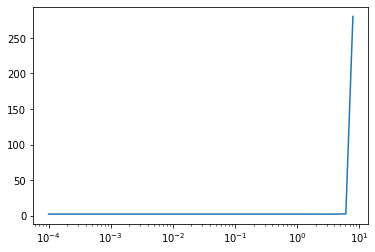

In [ ]:
learn.fit(1)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.5, cbs=cbs)

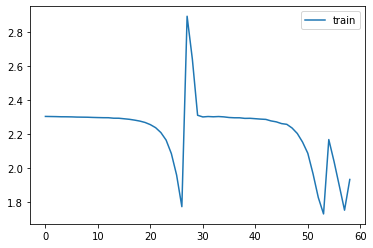

In [ ]:
learn.fit(1)

In [ ]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

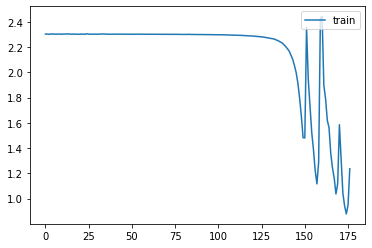

In [ ]:
learn.fit(3)

## A Generic Optimizer

In [ ]:
class SGD:
    def __init__(self, params, lr): self.params,self.lr,self.i=list(params),lr,0

    def step(self):
        with torch.no_grad():
            for p in self.params: self.param_step(p)
        self.i +=1

    def param_step(self, p): p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
optfunc = SGD
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs, opt_func=optfunc)

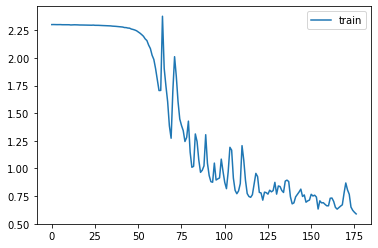

In [ ]:
learn.fit(3)

## Momentum

In [ ]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2
y1 = ys + torch.randn(100) * 0.1

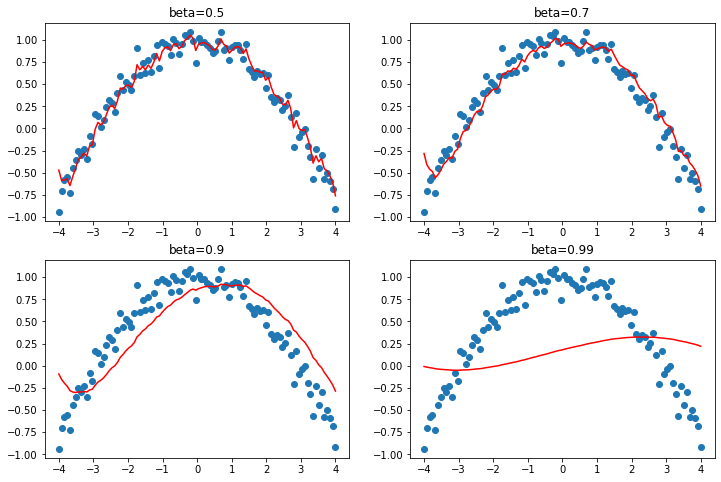

In [ ]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,y1)
    avg,res = 0,[]
    for yi in y1:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, mom=0.85):
        super().__init__(params, lr=lr)
        self.mom=mom

    def param_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = p.grad/2
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= lr * p.grad_avg

In [ ]:
optfunc = Momentum
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.01, cbs=cbs, opt_func=optfunc)

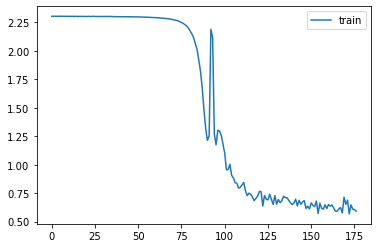

In [ ]:
learn.fit(3)

## RMSProp

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr, sqr_mom=0.99, eps=1e-1):
        super().__init__(params, lr=lr)
        self.sqr_mom,self.eps = sqr_mom,eps

    def param_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data) # p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
#         print(p.sqr_avg.sqrt())
        upd =  p.grad/(p.sqr_avg.sqrt() + self.eps)
#         print(upd)
#         import pdb; pdb.set_trace()
        p -= lr * upd

In [ ]:
optfunc = RMSProp
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.00001, cbs=cbs, opt_func=optfunc)

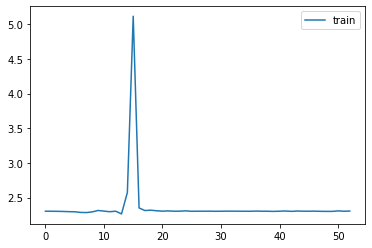

KeyboardInterrupt: 

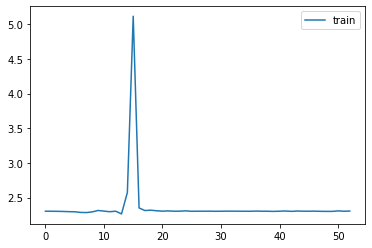

In [ ]:
learn.fit(3)

## Adam

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def param_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        p -= lr * unbias_avg / (p.sqr_avg + self.eps).sqrt()

In [ ]:
optfunc = Adam
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.00001, cbs=cbs, opt_func=optfunc)

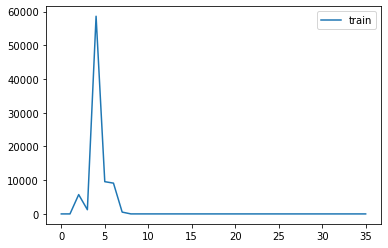

KeyboardInterrupt: 

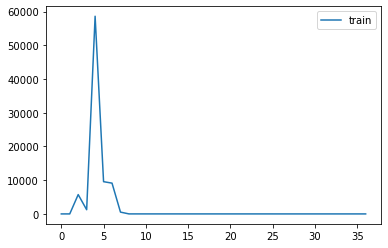

In [ ]:
learn.fit(3)